In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Make `src` dir can be imported
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))  # /aicup-predict-energy-generation
sys.path.append(project_root_path)

from src.utils import choose_device
from src.fe_tools import create_time_features, create_sinusoidal_transformation_by_number, create_sinusoidal_transformation_year_month_day, calculate_pressure_diff

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


import xgboost as xgb

In [2]:
df_raw_data = pd.read_csv('../data/processed_data/combined_data.csv')
df_raw_data['datetime'] = pd.to_datetime(df_raw_data['datetime'])
# make sure the sorting is correct
df_raw_data = df_raw_data.sort_values(by=['device','datetime']).reset_index(drop=True)

In [3]:
# parameterize the device for testing conveniently
df_device = choose_device(df_raw_data, 'L10')

## Preprocessing

In [4]:
df_device

,datetime,windspeed,pressure,temperature,humidity,sunlight,power,device
101673,2024-03-01 17:14:06,0.0,1017.48,15.59,94.30,652.92,0.12,L10
101674,2024-03-01 17:14:47,0.0,1017.48,15.66,94.04,682.50,0.12,L10
101675,2024-03-01 17:15:47,0.0,1017.47,15.74,94.10,750.00,0.14,L10
101676,2024-03-01 17:16:47,0.0,1017.46,15.78,94.09,738.33,0.14,L10
101677,2024-03-01 17:17:47,0.0,1017.49,15.80,94.08,660.83,0.12,L10
...,...,...,...,...,...,...,...,...
193008,2024-07-22 05:15:28,0.0,1004.27,27.36,88.72,102.50,0.00,L10
193009,2024-07-22 05:16:28,0.0,1004.25,27.37,88.78,115.00,0.01,L10
193010,2024-07-22 05:17:28,0.0,1004.29,27.37,88.88,129.17,0.01,L10
193011,2024-07-22 05:18:28,0.0,1004.29,27.38,88.88,144.17,0.01,L10


In [5]:
# columns_to_standardize = ['temperature', 'humidity', 'sunlight']


# scaler  = StandardScaler()
# df_standardized = df_device.copy()
# df_standardized[columns_to_standardize] = scaler.fit_transform(df_standardized[columns_to_standardize])

In [6]:
# remove outliers


In [7]:
def preprocess(df, columns_to_standardize, cols_for_drop):

    df_2 = col_remove(df, cols_for_drop)

    scaler = StandardScaler()
    df_standardized = df_2.copy()
    df_standardized[columns_to_standardize] = scaler.fit_transform(
        df_standardized[columns_to_standardize]
    )
    return df_standardized


def col_remove(df, cols_for_drop):

    df_result= df.copy()
    if cols_for_drop:
        df_result = df.drop(cols_for_drop, axis=1).copy()

    return df_result

base_columns = ['windspeed', 'pressure', 'temperature', 'humidity', 'sunlight']
cols_for_drop=['windspeed','pressure']
columns_to_standardize = [col for col in base_columns if col not in cols_for_drop]
df_standardized = preprocess(df_device, columns_to_standardize, cols_for_drop=cols_for_drop)

## Feature engineering

In [8]:
# df_fe_result = calculate_pressure_diff(df_standardized, column='pressure')
# df_fe_result

create sinusodial month mapping

In [9]:
month_numbers = list(range(1, 13))

# Create DataFrame
df_months = pd.DataFrame(month_numbers, columns=["month"])
df_months = create_sinusoidal_transformation_by_number(df_months, 'month', 12)
df_months

,month,month_sin,month_cos
0,1,5.000000e-01,8.660254e-01
1,2,8.660254e-01,5.000000e-01
2,3,1.000000e+00,6.123234e-17
3,4,8.660254e-01,-5.000000e-01
4,5,5.000000e-01,-8.660254e-01
5,6,1.224647e-16,-1.000000e+00
6,7,-5.000000e-01,-8.660254e-01
7,8,-8.660254e-01,-5.000000e-01
8,9,-1.000000e+00,-1.836970e-16
9,10,-8.660254e-01,5.000000e-01


#### General time frame

In [10]:
# Generate date range from 2023-01-01 to 2025-12-31
general_dates = pd.date_range(start="2023-01-01", end="2025-12-31")

# Create DataFrame and extract year, month, and day into separate columns
df_general_dates = pd.DataFrame({
    "year": general_dates.year,
    "month": general_dates.month,
    "day": general_dates.day
})
df_general_dates = create_sinusoidal_transformation_year_month_day(df_general_dates, 'general_ymd', 'year', 'month', 'day', 12)
df_general_dates

,year,month,day,general_ymd_sin,general_ymd_cos
0,2023,1,1,-5.000000e-01,-8.660254e-01
1,2023,1,2,8.660254e-01,5.000000e-01
2,2023,1,3,-1.000000e+00,-1.611765e-13
3,2023,1,4,8.660254e-01,-5.000000e-01
4,2023,1,5,-5.000000e-01,8.660254e-01
...,...,...,...,...,...
1091,2025,12,27,-6.359136e-11,1.000000e+00
1092,2025,12,28,-4.654404e-11,1.000000e+00
1093,2025,12,29,-8.770438e-11,1.000000e+00
1094,2025,12,30,-7.065706e-11,1.000000e+00


#### Aligns with a specific lunar calendar period

In [11]:
# Generate date range from 2023-01-01 to 2025-12-31
luner_dates = pd.date_range(start="2023-02-04", end="2025-02-03")

# Create DataFrame and extract year, month, and day into separate columns
df_luner_dates = pd.DataFrame({
    "year": luner_dates.year,
    "month": luner_dates.month,
    "day": luner_dates.day
})
df_luner_dates = create_sinusoidal_transformation_year_month_day(df_luner_dates, 'lunar_ymd', 'year', 'month', 'day', 365)
df_luner_dates

,year,month,day,lunar_ymd_sin,lunar_ymd_cos
0,2023,2,4,0.845249,-0.534373
1,2023,2,5,0.455907,-0.890028
2,2023,2,6,-0.060213,-0.998186
3,2023,2,7,-0.559589,-0.828770
4,2023,2,8,-0.903356,-0.428892
...,...,...,...,...,...
726,2025,1,30,0.377708,-0.925925
727,2025,1,31,-0.085965,0.996298
728,2025,2,1,0.566702,0.823923
729,2025,2,2,0.933837,0.357698


In [12]:
df_fe_result = create_time_features(df_standardized, 'datetime')
df_fe_result.head()

,datetime,temperature,humidity,sunlight,power,device,date,year,month,day,hour,min,day_of_week,week_of_year,quarter
101673,2024-03-01 17:14:06,-1.957708,0.952897,-0.610977,0.12,L10,2024-03-01,2024,3,1,17,14,4,9,1
101674,2024-03-01 17:14:47,-1.948416,0.942079,-0.609784,0.12,L10,2024-03-01,2024,3,1,17,14,4,9,1
101675,2024-03-01 17:15:47,-1.937797,0.944575,-0.607062,0.14,L10,2024-03-01,2024,3,1,17,15,4,9,1
101676,2024-03-01 17:16:47,-1.932488,0.944159,-0.607533,0.14,L10,2024-03-01,2024,3,1,17,16,4,9,1
101677,2024-03-01 17:17:47,-1.929833,0.943743,-0.610658,0.12,L10,2024-03-01,2024,3,1,17,17,4,9,1


In [15]:
df_fe_result_sinusoidal_time = pd.merge(df_fe_result, df_general_dates, how='left',  on=['year', 'month', 'day'])
# df_fe_result_sinusoidal_time = df_fe_result
df_fe_result_sinusoidal_time.head()
# pe_check = df_fe_result_sinusoidal_time[[ 'date', 'year','month','general_ymd_0_sin','general_ymd_0_cos','general_ymd_1_sin','general_ymd_1_cos']].drop_duplicates()

,datetime,temperature,humidity,sunlight,power,device,date,year,month,day,hour,min,day_of_week,week_of_year,quarter,general_ymd_sin,general_ymd_cos
0,2024-03-01 17:14:06,-1.957708,0.952897,-0.610977,0.12,L10,2024-03-01,2024,3,1,17,14,4,9,1,3.963436e-15,1.0
1,2024-03-01 17:14:47,-1.948416,0.942079,-0.609784,0.12,L10,2024-03-01,2024,3,1,17,14,4,9,1,3.963436e-15,1.0
2,2024-03-01 17:15:47,-1.937797,0.944575,-0.607062,0.14,L10,2024-03-01,2024,3,1,17,15,4,9,1,3.963436e-15,1.0
3,2024-03-01 17:16:47,-1.932488,0.944159,-0.607533,0.14,L10,2024-03-01,2024,3,1,17,16,4,9,1,3.963436e-15,1.0
4,2024-03-01 17:17:47,-1.929833,0.943743,-0.610658,0.12,L10,2024-03-01,2024,3,1,17,17,4,9,1,3.963436e-15,1.0


In [ ]:
pe_check['ym'] = pe_check['year'].astype(str) + '-' + pe_check['month'].astype(str)
pe_check_2 = pe_check.set_index('date')
pe_check_2

,year,month,general_ymd_0_sin,general_ymd_0_cos,general_ymd_1_sin,general_ymd_1_cos,ym
date,,,,,,,
2024-03-01,2024,3,0.988018,-0.154341,-0.998962,-0.045559,2024-3
2024-03-02,2024,3,0.988018,-0.154341,-0.998962,-0.045559,2024-3
2024-03-03,2024,3,0.988018,-0.154341,-0.998962,-0.045559,2024-3
2024-03-04,2024,3,0.988018,-0.154341,-0.998962,-0.045559,2024-3
2024-03-05,2024,3,0.988018,-0.154341,-0.998962,-0.045559,2024-3
...,...,...,...,...,...,...,...
2024-07-18,2024,7,0.988018,-0.154341,-0.998962,-0.045559,2024-7
2024-07-19,2024,7,0.988018,-0.154341,-0.998962,-0.045559,2024-7
2024-07-20,2024,7,0.988018,-0.154341,-0.998962,-0.045559,2024-7


In [17]:
def plot_sinusoidal_transformations(df, col_name):
    # Set up the plot
    plt.figure(figsize=(14, 6))
    
    # Plot the sine transformation
    plt.plot(df[f'{col_name}_sin'], label=f'{col_name}_sin', color='b')
    
    # Plot the cosine transformation
    plt.plot(df[f'{col_name}_cos'], label=f'{col_name}_cos', color='r')
    
    # Labeling the plot
    plt.title(f'Sinusoidal Transformations for {col_name}')
    plt.xlabel('Index')
    plt.ylabel('Transformed Value')
    plt.legend()
    
    # Show the plot
    plt.show()

# Assuming your DataFrame has the sinusoidal transformations
plot_sinusoidal_transformations(pe_check_2, 'general_ymd')

KeyError: 'general_ymd_sin'

<Figure size 1400x600 with 0 Axes>

In [17]:
# input data
drop_cols = ['locationcode', 'year']
df_fe_result_sinusoidal_time = df_fe_result_sinusoidal_time.drop(drop_cols, axis=1)
df_fe_result_sinusoidal_time

KeyError: "['locationcode'] not found in axis"

## Check before splitting

In [15]:
df_fe_result_sinusoidal_time.describe()

,datetime,temperature,humidity,sunlight,power,month,day,hour,min,day_of_week,week_of_year,quarter
count,91340,9.134000e+04,9.134000e+04,9.134000e+04,91340.000000,91340.000000,91340.000000,91340.000000,91340.000000,91340.000000,91340.0,91340.00000
mean,2024-05-11 17:44:55.440081152,5.949454e-16,3.260998e-16,5.600950e-17,173.846974,4.879450,14.734235,11.205967,29.391504,3.078476,19.310488,1.94307
min,2024-03-01 17:14:06,-2.217871e+00,-2.357184e+00,-6.365004e-01,0.000000,3.000000,1.000000,4.000000,0.000000,0.000000,9.0,1.00000
25%,2024-04-05 10:31:04,-7.285702e-01,-7.531154e-01,-5.425404e-01,1.310000,4.000000,7.000000,8.000000,14.000000,1.000000,14.0,2.00000
50%,2024-05-12 05:08:51,-1.378940e-01,1.219444e-01,-3.740946e-01,10.560000,5.000000,14.000000,11.000000,29.000000,3.000000,19.0,2.00000
75%,2024-06-13 08:54:26,5.775543e-01,9.841050e-01,5.369013e-02,79.730000,6.000000,22.000000,15.000000,44.000000,5.000000,24.0,2.00000
max,2024-07-22 05:19:28,3.127417e+00,1.190075e+00,4.111428e+00,2393.100000,7.000000,31.000000,18.000000,59.000000,6.000000,30.0,3.00000
std,NaN,1.000005e+00,1.000005e+00,1.000005e+00,405.009026,1.361935,8.757721,3.918883,17.309528,2.003215,5.74327,0.60572


In [16]:
df_fe_result_sinusoidal_time = df_fe_result_sinusoidal_time.set_index('datetime')

In [17]:
df_fe_result_sinusoidal_time.head()

,temperature,humidity,sunlight,power,device,date,month,day,hour,min,day_of_week,week_of_year,quarter
datetime,,,,,,,,,,,,,
2024-03-01 17:14:06,-1.957708,0.952897,-0.610977,0.12,L10,2024-03-01,3,1,17,14,4,9,1
2024-03-01 17:14:47,-1.948416,0.942079,-0.609784,0.12,L10,2024-03-01,3,1,17,14,4,9,1
2024-03-01 17:15:47,-1.937797,0.944575,-0.607062,0.14,L10,2024-03-01,3,1,17,15,4,9,1
2024-03-01 17:16:47,-1.932488,0.944159,-0.607533,0.14,L10,2024-03-01,3,1,17,16,4,9,1
2024-03-01 17:17:47,-1.929833,0.943743,-0.610658,0.12,L10,2024-03-01,3,1,17,17,4,9,1


In [18]:
df_fe_result_sinusoidal_time.date.value_counts()

date
2024-07-05    840
2024-07-04    840
2024-07-07    839
2024-06-23    838
2024-06-22    838
             ... 
2024-03-01     52
2024-05-01     44
2024-07-09     19
2024-06-11     18
2024-07-22     14
Name: count, Length: 138, dtype: int64

In [19]:
df_fe_result_sinusoidal_time[(df_fe_result_sinusoidal_time['month'] == 6) & (df_fe_result_sinusoidal_time['day'] == 11)]

,temperature,humidity,sunlight,power,device,date,month,day,hour,min,day_of_week,week_of_year,quarter
datetime,,,,,,,,,,,,,
2024-06-11 18:34:10,-0.218863,0.800189,-0.628536,0.01,L10,2024-06-11,6,11,18,34,1,24,2
2024-06-11 18:35:08,-0.200280,0.760243,-0.629342,0.01,L10,2024-06-11,6,11,18,35,1,24,2
2024-06-11 18:36:08,-0.194971,0.755250,-0.630216,0.01,L10,2024-06-11,6,11,18,36,1,24,2
2024-06-11 18:37:08,-0.192316,0.758578,-0.630989,0.00,L10,2024-06-11,6,11,18,37,1,24,2
2024-06-11 18:38:08,-0.193643,0.761907,-0.631695,0.00,L10,2024-06-11,6,11,18,38,1,24,2
2024-06-11 18:39:08,-0.194971,0.738606,-0.632300,0.00,L10,2024-06-11,6,11,18,39,1,24,2
2024-06-11 18:40:08,-0.197625,0.743183,-0.632838,0.00,L10,2024-06-11,6,11,18,40,1,24,2
2024-06-11 18:41:08,-0.202935,0.736941,-0.633342,0.00,L10,2024-06-11,6,11,18,41,1,24,2
2024-06-11 18:42:08,-0.205589,0.752753,-0.633812,0.00,L10,2024-06-11,6,11,18,42,1,24,2


## Train/Test split

In [20]:
def get_test_size(days):
    # since the data is one minute one row
    return days*24*60

In [21]:
day_gap = 24*60

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size=get_test_size(5), gap = day_gap)

In [23]:
def split_train_test(df, plot=False):
    fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        df_train = df.iloc[train_idx]
        df_test = df.iloc[val_idx]

        if plot:

            df_train['power'].plot(ax=axs[fold],
                                label='Training Set',
                                title = f'Data Train/Test Split Fold {fold}')
            df_test['power'].plot(ax=axs[fold], label='Test Set')
            axs[fold].axvline(df_test.index.min(), color='black', ls='--')

            fold += 1

    return df_train, df_test

In [24]:
df_fe_result_sinusoidal_time.columns

Index(['temperature', 'humidity', 'sunlight', 'power', 'device', 'date',
       'month', 'day', 'hour', 'min', 'day_of_week', 'week_of_year',
       'quarter'],
      dtype='object')

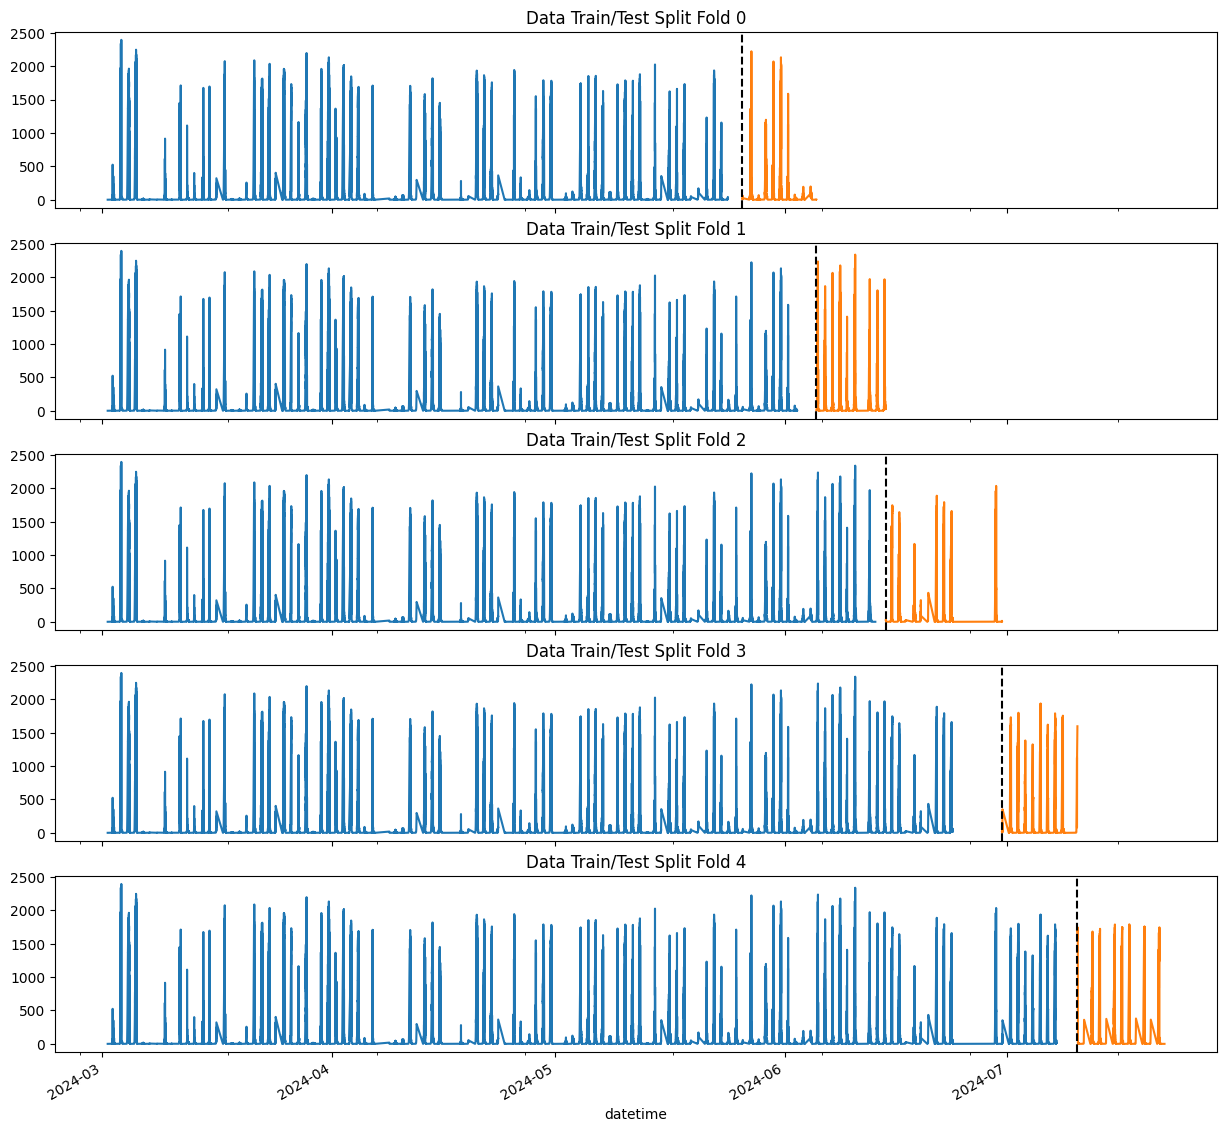

In [25]:
df_train, df_test = split_train_test(df=df_fe_result_sinusoidal_time, plot=True)

## Train Using Cross Validation

In [26]:
day_gap = 24*60
tss = TimeSeriesSplit(n_splits=5, test_size=get_test_size(2), gap = day_gap)

In [27]:
drop_cols = ['power', 'device', 'date']
target = ['power']

In [28]:
df = df_fe_result_sinusoidal_time

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    df_train = df.iloc[train_idx]
    df_valid = df.iloc[val_idx]

    TARGET = 'power'

    X_train = df_train.drop(drop_cols, axis=1)
    y_train = df_train[TARGET]
    
    X_valid = df_valid.drop(drop_cols, axis=1)
    y_valid = df_valid[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.1,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=100,
        max_depth=10,
        learning_rate=1e-2,
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

    y_pred = reg.predict(X_valid)
    preds.append(y_pred)
    score = sum(abs(y_pred - y_valid))
    scores.append(score)

In [29]:
np.mean(scores)

np.float64(218930.6636535807)